## Apress - Industrialized Machine Learning Examples

Andreas Francois Vermeulen
2019

### This is an example add-on to a book and needs to be accepted as part of that copyright.

## Chapter-009-013-Recommender-02

In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

import matplotlib.pyplot as plt 

In [2]:
articles_raw_df = pd.read_csv('../../data/articles/shared_articles.csv')
print('Loaded %0d articles with %0d columns' % (articles_raw_df.shape[0], articles_raw_df.shape[1]))

Loaded 3122 articles with 13 columns


In [3]:
articles_df = articles_raw_df[articles_raw_df['eventType'] == 'CONTENT SHARED']
print('Filtered %0d articles with %0d columns' % (articles_df.shape[0], articles_df.shape[1]))

Filtered 3047 articles with 13 columns


In [4]:
print(articles_df.head(5))

    timestamp       eventType            contentId       authorPersonId  \
1  1459193988  CONTENT SHARED -4110354420726924665  4340306774493623681   
2  1459194146  CONTENT SHARED -7292285110016212249  4340306774493623681   
3  1459194474  CONTENT SHARED -6151852268067518688  3891637997717104548   
4  1459194497  CONTENT SHARED  2448026894306402386  4340306774493623681   
5  1459194522  CONTENT SHARED -2826566343807132236  4340306774493623681   

       authorSessionId authorUserAgent authorRegion authorCountry contentType  \
1  8940341205206233829             NaN          NaN           NaN        HTML   
2  8940341205206233829             NaN          NaN           NaN        HTML   
3 -1457532940883382585             NaN          NaN           NaN        HTML   
4  8940341205206233829             NaN          NaN           NaN        HTML   
5  8940341205206233829             NaN          NaN           NaN        HTML   

                                                 url  \
1  htt

In [5]:
interactions_df = pd.read_csv('../../data/articles/users_interactions.csv')
print('Loaded %0d articles with %0d columns' % (interactions_df.shape[0], interactions_df.shape[1]))

Loaded 72312 articles with 8 columns


In [6]:
interactions_df.head(10)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN
5,1465413742,VIEW,310515487419366995,-8763398617720485024,1395789369402380392,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR
6,1465415950,VIEW,-8864073373672512525,3609194402293569455,1143207167886864524,NaN,NaN,NaN
7,1465415066,VIEW,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
8,1465413762,VIEW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
9,1465413771,VIEW,3064370296170038610,3609194402293569455,1143207167886864524,NaN,NaN,NaN


In [7]:
interactions_count = pd.DataFrame(interactions_df[['eventType','contentId']].groupby(['eventType']).count())
interactions_count.columns=['Event_Count']
interactions_count.reset_index(level=0, inplace=True)
print(interactions_count)                               

         eventType  Event_Count
0         BOOKMARK         2463
1  COMMENT CREATED         1611
2           FOLLOW         1407
3             LIKE         5745
4             VIEW        61086


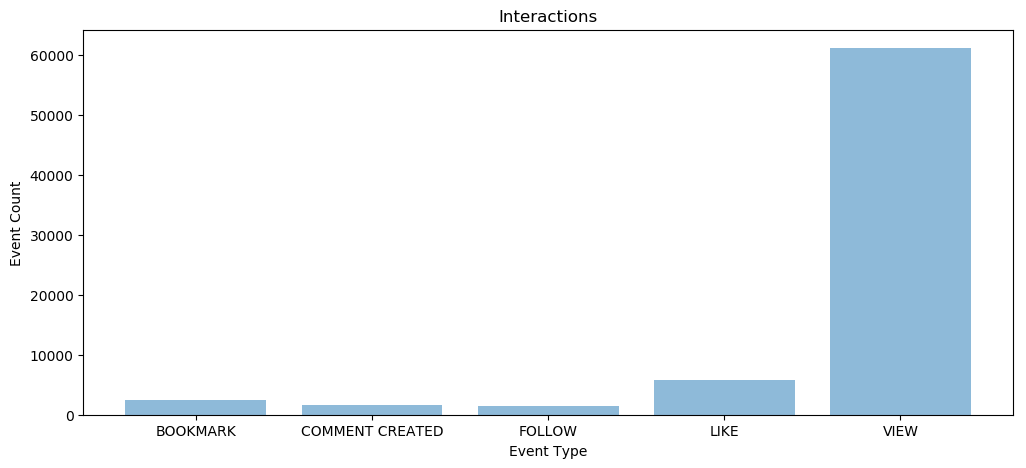

In [8]:
y_value=np.array(interactions_count['eventType'])
y_pos=np.arange(y_value.shape[0])
x_value=np.array(interactions_count['Event_Count'])
plt.rcdefaults()
fig=plt.figure(figsize=(12,5))
plt.bar(y_pos, x_value, align='center', alpha=0.5)
plt.xticks(y_pos, y_value)
plt.xlabel('Event Type')
plt.ylabel('Event Count')
plt.title('Interactions')
plt.show()

In [9]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

In [10]:
interactions_df['eventStrength'] = interactions_df['eventType'].apply(lambda x: event_type_strength[x])

In [11]:
print('number of interactions: %d' % len(interactions_df))

number of interactions: 72312


In [12]:
users_interactions_count_df = interactions_df.groupby(['personId', 'contentId']).size().groupby('personId').size()
print('number of users: %d' % len(users_interactions_count_df))

number of users: 1895


In [13]:
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('number users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

number users with at least 5 interactions: 1140


In [14]:
print(users_with_enough_interactions_df.shape)

(1140, 1)


In [15]:
interactions_from_selected_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')

In [16]:
print('number of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

number of interactions from users with at least 5 interactions: 69868


In [17]:
def smooth_user_preference(x):
    return math.log(1+x, 2)

In [18]:
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()

In [19]:
print('Number of unique user/item interactions: %d' % len(interactions_full_df))

Number of unique user/item interactions: 39106


In [20]:
print(interactions_full_df.head(5))

              personId            contentId  eventStrength
0 -9223121837663643404 -8949113594875411859       1.000000
1 -9223121837663643404 -8377626164558006982       1.000000
2 -9223121837663643404 -8208801367848627943       1.000000
3 -9223121837663643404 -8187220755213888616       1.000000
4 -9223121837663643404 -7423191370472335463       3.169925


In [21]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'], 
                                   test_size=0.20,
                                   random_state=42)

In [22]:
print('Number of interactions on Train set: %d' % len(interactions_train_df))

Number of interactions on Train set: 31284


In [23]:
print('Number of interactions on Test set: %d' % len(interactions_test_df))

Number of interactions on Test set: 7822


In [24]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')

In [25]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [26]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(articles_df['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['contentId'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()    

# Popularity model
A common (and usually hard-to-beat) baseline approach is the Popularity model. This model is not actually personalized - it simply recommends to a user the most popular items that the user has not previously consumed. As the popularity accounts for the "wisdom of the crowds", it usually provides good recommendations, generally interesting for most people.
Ps. The main objective of a recommender system is to leverage the long-tail items to the users with very specific interests, which goes far beyond this simple technique.

In [27]:
#Computes the most popular items
item_popularity_df = interactions_full_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()

In [28]:
print(item_popularity_df.head(5))

             contentId  eventStrength
0 -4029704725707465084     307.733799
1 -6783772548752091658     233.762157
2  -133139342397538859     228.024567
3 -8208801367848627943     197.107608
4 -6843047699859121724     193.825208


In [29]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)] \
                               .sort_values('eventStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, articles_df)

In [30]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)

Evaluating Popularity recommendation model...
1139 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.2417540271030427, 'recall@10': 0.37292252620813093}


In [31]:
pop_detailed_results_df.head(10)

,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
76,3609194402293569455,50,28,192,0.260417,0.145833
17,-2626634673110551643,25,12,134,0.186567,0.089552
16,-1032019229384696495,23,13,130,0.176923,0.100000
10,-1443636648652872475,9,5,117,0.076923,0.042735
82,-2979881261169775358,40,25,88,0.454545,0.284091
161,-3596626804281480007,18,12,80,0.225000,0.150000
65,1116121227607581999,33,20,73,0.452055,0.273973
81,692689608292948411,23,17,69,0.333333,0.246377
106,-9016528795238256703,18,14,69,0.260870,0.202899
52,3636910968448833585,28,21,68,0.411765,0.308824


# Content-Based Filtering model
Content-based filtering approaches leverage description or attributes from items the user has interacted to recommend similar items. 
It depends only on the user previous choices, making this method robust to avoid the cold-start problem.

### Ignoring stopwords (words with no semantics) from English and Portuguese (as we have a corpus with mixed languages)

In [35]:
!pip install -U nltk

  Stored in directory: C:\Users\AndreVermeulen\AppData\Local\pip\Cache\wheels\97\8a\10\d646015f33c525688e91986c4544c68019b19a473cb33d3b55
Successfully built nltk
  Found existing installation: nltk 3.4
    Uninstalling nltk-3.4:
      Successfully uninstalled nltk-3.4


In [36]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AndreVermeulen\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [37]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

### Trains a model with vectors size at 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords

In [39]:
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

In [40]:
item_ids = articles_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(articles_df['title'] + "" + articles_df['text'])
tfidf_feature_names = vectorizer.get_feature_names()

In [41]:
print(tfidf_matrix.shape)

(3047, 5000)


In [42]:
for i in range(20):
    print(' %2.0d => %0.4f - %0.4f' % (i, tfidf_matrix[i,0], tfidf_matrix[i,1]))

  0 => 0.0000 - 0.0000
  1 => 0.0957 - 0.0000
  2 => 0.0000 - 0.0000
  3 => 0.0000 - 0.0000
  4 => 0.0000 - 0.0398
  5 => 0.0000 - 0.0000
  6 => 0.0000 - 0.0000
  7 => 0.0000 - 0.0134
  8 => 0.0000 - 0.0151
  9 => 0.0000 - 0.0000
 10 => 0.0000 - 0.0000
 11 => 0.0104 - 0.0000
 12 => 0.0000 - 0.0000
 13 => 0.0000 - 0.0145
 14 => 0.0000 - 0.0000
 15 => 0.0000 - 0.0000
 16 => 0.0000 - 0.0276
 17 => 0.0000 - 0.0000
 18 => 0.0000 - 0.0000
 19 => 0.0000 - 0.0300


## Done

In [43]:
import datetime
now = datetime.datetime.now()
print('Done!',str(now))

Done! 2019-04-24 21:47:11.624742
